# Difftest Results

Connect to results database:

In [1]:
import db
from db import *

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [2]:
import pandas as pd

session = db.make_session()

TABLE_NAMES = ["CLSmith", "CLSmith w. cldrive", "GitHub", "CLgen"]
TABLES = [CLSmithResult, cldriveCLSmithResult, GitHubResult, CLgenResult]

data = [
    ("#. Programs", [session.query(t.program_id).group_by(t.program_id).count() for t in TABLES]),
    ("#. Testbeds", [session.query(t.testbed_id).group_by(t.testbed_id).count() for t in TABLES]),
    ("#. Params", [session.query(t.params_id).group_by(t.params_id).count() for t in TABLES]),
    ("#. Results", [session.query(t).count() for t in TABLES])
]
i, d = zip(*data)
overview = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
overview

,CLSmith,CLSmith w. cldrive,GitHub,CLgen
#. Programs,10001,10001,9238,1000
#. Testbeds,3,3,2,2
#. Params,4,4,4,4
#. Results,85328,75230,84399,8000


# Experimental Setup

### TestBeds

A testbed is a combination of host platform and OpenCL device.

In [3]:
import sqlalchemy as sql

DEVICES = {  # shorthand device names
    "GeForce GTX 1080": "NVIDIA GTX 1080",
    "Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620",
    "Olcgrind Simulator": "Oclgrind",
}

DRIVERS = {
    "Oclgrind 16.10": "16.10"
}

q = session.query(Testbed).order_by(sql.func.field(Testbed.devtype, 'GPU', 'CPU', 'Emulator'))

data = []
for testbed in q:
    data.append(
        (testbed.id, [
            testbed.host, DEVICES.get(testbed.device, testbed.device),
            DRIVERS.get(testbed.driver, testbed.driver), testbed.opencl, testbed.devtype] +
         [session.query(t.testbed).filter(t.testbed == testbed).count() for t in TABLES]))
i, d = zip(*data)
testbeds = pd.DataFrame(list(d), index=i, columns=["Operating System", "Device", "Driver", "OpenCL", "Device type"] + [f"#. {t}" for t in TABLE_NAMES])
testbeds

,Operating System,Device,Driver,OpenCL,Device type,#. CLSmith,#. CLSmith w. cldrive,#. GitHub,#. CLgen
3,Ubuntu 16.04 64bit,NVIDIA GTX 1080,375.39,1.2,GPU,120012,104079,142341,12000
9,Ubuntu 16.04 64bit,Intel E5-2620,1.2.0.25,2.0,CPU,120012,120012,110856,12000
11,Ubuntu 16.04 64bit,Oclgrind Simulator,16.10,1.2,Emulator,15960,1599,0,0


In [4]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
import os
data = []
for testbed in session.query(Testbed):
    data.append([
        testbed.platform, testbed.device, DRIVERS.get(testbed.driver, testbed.driver),
        testbed.opencl, testbed.host, testbed.devtype])
table = pd.DataFrame(data, index=range(1, len(data)+1), columns=[
    "Platform", "Device", "Driver", "OpenCL", "Operating system", "Device type"])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,Platform,Device,Driver,OpenCL,Operating system,Device type
1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU
2,Intel(R) OpenCL,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU
3,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator


## Runtime Parameters

### cl_launcher

In [5]:
q = session.query(cl_launcherParams).order_by(
        cl_launcherParams.gsize_x, cl_launcherParams.gsize_y, cl_launcherParams.gsize_z,
        cl_launcherParams.lsize_x, cl_launcherParams.lsize_y, cl_launcherParams.lsize_z,
        cl_launcherParams.optimizations)

data = []
for param in q:
    nresult_param = session.query(CLSmithResult).filter(CLSmithResult.params == param).count()
    data.append((
        param.id, [param.gsize, param.lsize, param.optimizations_on_off, nresult_param]))
i, d = zip(*data)

cl_launcher_params = pd.DataFrame(list(d), index=i, columns=[
    "Global size", "Local size", "Optimizations", "#. CLSmith"])
cl_launcher_params

,Global size,Local size,Optimizations,#. CLSmith
4,"(1, 1, 1)","(1, 1, 1)",off,20002
3,"(1, 1, 1)","(1, 1, 1)",on,25322
2,"(128, 16, 1)","(32, 1, 1)",off,20002
1,"(128, 16, 1)","(32, 1, 1)",on,20002


### cldrive

In [6]:
CLDRIVE_TABLE_NAMES = ["CLSmith w. cldrive", "GitHub", "CLgen"]
CLDRIVE_TABLES = [cldriveCLSmithResult, GitHubResult, CLgenResult]

q = session.query(cldriveParams).order_by(
        cldriveParams.size,
        cldriveParams.gsize_x, cldriveParams.gsize_y, cldriveParams.gsize_z,
        cldriveParams.lsize_x, cldriveParams.lsize_y, cldriveParams.lsize_z,
        cldriveParams.generator, cldriveParams.scalar_val, cldriveParams.optimizations)

data = []
for param in q:
    data.append((
        param.id,
        [param.size, param.generator, param.scalar_val, param.gsize,
         param.lsize, param.optimizations_on_off] + [
            session.query(t).filter(t.params == param).count()
            for t in CLDRIVE_TABLES
        ]))
i, d = zip(*data)

cldrive_params = pd.DataFrame(list(d), index=i, columns=[
    "Size", "Generator", "Scalar Val", "Global size", "Local size",
    "Optimizations"] + [f"#. {t}" for t in CLDRIVE_TABLE_NAMES])
cldrive_params

,Size,Generator,Scalar Val,Global size,Local size,Optimizations,#. CLSmith w. cldrive,#. GitHub,#. CLgen
11,256,arange,None,"(1, 1, 1)","(1, 1, 1)",off,20002,18476,2000
10,256,arange,None,"(1, 1, 1)","(1, 1, 1)",on,20535,18476,2000
12,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",off,14691,26538,2000
9,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",on,20002,20909,2000


In [7]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
data = []
for param in q:
    data.append([param.size, param.gsize, param.lsize, param.optimizations_on_off])
table = pd.DataFrame(data, index=range(1, len(data)+1), columns=[
    "Dataset Size", "Global size", "Workgroup size", "OpenCL Optimizations"])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/cldrive-params.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/cldrive-params.tex" && git push
table

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,Dataset Size,Global size,Workgroup size,OpenCL Optimizations
1,256,"(1, 1, 1)","(1, 1, 1)",off
2,256,"(1, 1, 1)","(1, 1, 1)",on
3,4096,"(128, 16, 1)","(32, 1, 1)",off
4,4096,"(128, 16, 1)","(32, 1, 1)",on


# Experimental Results

## Runtimes

Excluding runs which terminated in non-zero status:

In [8]:
import numpy as np

runtimes = [np.array(session.query(table.runtime).filter(table.status == 0).all()) for table in TABLES]
data = [
    ("Min", [r.min() for r in runtimes]),
    ("Median", [np.median(r) for r in runtimes]),
    ("Mean", [r.mean() for r in runtimes]),
    ("Max", [r.max() for r in runtimes])
]
i, d = zip(*data)
runtimes = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
runtimes

,CLSmith,CLSmith w. cldrive,GitHub,CLgen
Min,0.026003,2.279470,2.346580,2.180390
Median,1.224455,3.837550,3.769885,5.874140
Mean,1.913065,4.278828,3.653087,4.262695
Max,58.667400,47.763300,55.092600,10.941300


## Outcomes

**Write `outcome` and `classification` fields in tables**

In [51]:
from collections import Counter
from progressbar import ProgressBar

# Group outcomes into less-granular classifications, as in the CLSmith paper.
# This table maps <outcome>: <classification>
CLASSIFICATIONS = {
    '__NOT_IMPLEMENTED_YET__': 'Wrong code',
    'CL_BUILD_PROGRAM _FAILURE': 'Build failure',
    'CL_INVALID_COMMAND_QUEUE': 'Runtime crash',
    'CL_INVALID_KERNEL_NAME': 'Build failure',
    'CL_INVALID_VALUE': 'Runtime crash',
    'CL_OUT_OF_HOST_MEMORY': 'Runtime crash',
    'CL_OUT_OF_RESOURCES': 'Runtime crash',
    'cldrive Error': 'Invalid testcase',
    'clWaitForEvents()': 'Runtime crash',
    'Multiple OpenCL kernels': 'Invalid testcase',
    'No OpenCL kernel': 'Invalid testcase',
    'Preprocessing Failed': 'Invalid testcase',
    'Segmentation Fault': 'Build failure',
    'SIGBUS': 'Runtime crash',
    'Timeout': 'Invalid testcase',
    'Unsupported Program': 'Invalid testcase',
    'z_Okay': 'Okay',
    'INVALID_WORK_GROUP_SIZE': 'Invalid testcase',
    'UnicodeError': 'Invalid testcase',
}
print("Possible classifications:", ", ".join(f"'{s}'" for s in sorted(set(CLASSIFICATIONS.values()))))


def lookup_status(status):
    return {
        -11: "Segmentation Fault",
        -9: "Timeout",
        0: "z_Okay",
        1024: "Preprocessing Failed",
        1025: "UnicodeError",
    }[status]


def get_cl_launcher_outcome(result):
    if result.status == 1:
        # exit status of 1 indicates that cl_launcher exited after an OpenCL API call error
        prev = None
        for line in reversed(result.stderr.split('\n')):
            if line == "Error found (callback):":
                # Interpret CLSmith error callback messages: the following line describes the error
                return prev.split()[0]
            elif line.startswith("Error"):
                # Interpret CLSmith error messages
                return {
                    "Error enqueueing kernel: -6": "CL_OUT_OF_HOST_MEMORY",
                    "Error sending finish command: -36": "CL_INVALID_COMMAND_QUEUE",
                    "Error building program: -11": "CL_BUILD_PROGRAM _FAILURE",
                    "Error creating kernel: -46": "CL_INVALID_KERNEL_NAME",
                    "Error enqueueing kernel: -5": "CL_OUT_OF_RESOURCES",
                }.get(line, line)
            prev = line
        else:  # should never happen
            raise LookupError
    else:
        return lookup_status(result.status)


def get_cldrive_outcome(result):
    if result.status == 1:
        # exit status of 1
        line = result.stderr.split('\n')[-2]  # last line contains the Exception line
        if line.startswith('cldrive.args.OpenCLValueError'):
            return 'Unsupported Program'
        elif line.startswith('ValueError: unsupported data type'):
            return 'cldrive Error'
        elif line.startswith('TypeError: unsupported operand type'):
            return 'cldrive Error'
        elif line.startswith('TypeError: _set_args() takes'):
            return 'cldrive Error'
        elif line.startswith('ValueError: could not broadcast input array from shape'):
            return 'cldrive Error'
        else:
            # This table maps <exception line>: <outcome>
            return {
                'AssertionError': 'cldrive Error',
                'cldrive.driver.PorcelainError: SIGBUS': 'SIGBUS',
                'cldrive.driver.PorcelainError: SIGSEGV': 'Segmentation Fault',
                'cldrive.driver.Timeout: 60': 'Timeout',
                'EOFError: Ran out of input': 'cldrive Error',
                'KeyError: \'outputs\'': 'cldrive Error',
                'LookupError: source contains more than one kernel definition': 'Multiple OpenCL kernels',
                'LookupError: source contains no kernel definitions.': 'No OpenCL kernel',
                'pyopencl.cffi_cl.LogicError: clEnqueueNDRangeKernel failed: INVALID_WORK_GROUP_SIZE': 'INVALID_WORK_GROUP_SIZE',
                'pyopencl.cffi_cl.LogicError: clWaitForEvents failed: <unknown error -9999>': 'clWaitForEvents()',
                'pyopencl.cffi_cl.RuntimeError: clEnqueueNDRangeKernel failed: OUT_OF_HOST_MEMORY': 'CL_OUT_OF_HOST_MEMORY',
                'pyopencl.cffi_cl.RuntimeError: clEnqueueNDRangeKernel failed: OUT_OF_RESOURCES': 'CL_OUT_OF_RESOURCES',
                'RuntimeError': 'cldrive Error',
                'ValueError: failed to set kernel args': 'cldrive Error',
            }.get(line, line)
    else:
        return lookup_status(result.status)

session.rollback()

# cl_launcher result outcomes and classifications
print("CLSmith ...")
for result in ProgressBar()(session.query(CLSmithResult).all()):
    result.outcome = get_cl_launcher_outcome(result)
    result.classification = CLASSIFICATIONS[result.outcome]
    
    # determine if output differs from the majority (if there is one)
    if result.status == 0:
        outputs = [x[0] for x in session.query(CLSmithResult.stdout)\
            .filter(CLSmithResult.program == result.program,
                    CLSmithResult.params == result.params,
                    CLSmithResult.status == 0)]
        if len(outputs) > 1:
            majority_output = Counter(outputs).most_common(1)[0][0]
            if result.stdout != majority_output:
                result.classification = "Wrong code"
session.commit()

# cldrive results outcomes and classifications
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    print(f"{name} ...")
    for result in ProgressBar()(session.query(table).all()):
        result.outcome = get_cldrive_outcome(result)
        result.classification = CLASSIFICATIONS[result.outcome]
        
        # determine if output differs from the majority (if there is one)
        if result.status == 0:
            outputs = [x[0] for x in session.query(table.stdout)\
                .filter(table.program == result.program,
                        table.params == result.params,
                        table.status == 0)]
            if len(outputs) > 1:
                majority_output = Counter(outputs).most_common(1)[0][0]
                if result.stdout != majority_output:
                    result.classification = "Wrong code"
    session.commit()

Possible classifications: 'Build failure', 'Invalid testcase', 'Okay', 'Runtime crash', 'Wrong code'
CLSmith ...


100% (89613 of 89613) |###############################| Elapsed Time: 0:05:17 Time: 0:05:17


CLSmith w. cldrive ...


100% (75230 of 75230) |###############################| Elapsed Time: 0:00:41 Time: 0:00:41


GitHub ...


100% (84399 of 84399) |###############################| Elapsed Time: 0:01:59 Time: 0:01:59


CLgen ...


100% (8310 of 8310) |#################################| Elapsed Time: 0:00:50 Time: 0:00:50


**Pandas tables of outcomes**

In [53]:
outcomes = {}

r = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.outcome, sql.func.count(CLSmithResult.outcome)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.outcome).order_by(sql.desc(sql.func.count(CLSmithResult.outcome)))

    for outcome, count in q.all():
        ratio = (count / nresult) * 100
        r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
outcomes["CLSmith"] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Total Results"])
        
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.outcome, sql.func.count(table.outcome)).filter(
            table.testbed == testbed).group_by(table.outcome).order_by(
                sql.desc(sql.func.count(table.outcome)))

        for outcome, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
    outcomes[name] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Total Results"])

print("done.")

done.


**Detecting wrong-code errors:**

In [87]:
classifications = {}

classificationsSort = [
    'Invalid testcase',
    'Build failure',
    'Runtime crash',
    'Wrong code',
    'Okay'
]

def escape(val):
    if val is None:
        return val
    else:
        return str(classificationsSort.index(val)) + ". " + val

r = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.classification, sql.func.count(CLSmithResult.classification)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.classification).order_by(
            sql.desc(sql.func.count(CLSmithResult.classification)))

    for val, count in q.all():
        ratio = (count / nresult) * 100
        r.append((DEVICES.get(testbed.device, testbed.device), escape(val), count, ratio))
classifications["CLSmith"] = pd.DataFrame(r, columns=["Device", "Classification", "Count", "% of Total Results"])
        
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.classification, sql.func.count(table.classification)).filter(
            table.testbed == testbed).group_by(table.classification).order_by(
                sql.desc(sql.func.count(table.classification)))

        for val, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), escape(val), count, ratio))
    classifications[name] = pd.DataFrame(r, columns=["Device", "Classification", "Count", "% of Total Results"])

print("done.")

done.


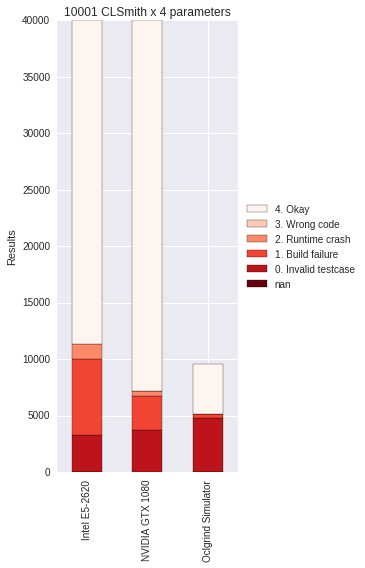

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
%matplotlib inline

def plot_outcomes(table, name, dictname=outcomes, key='Outcome'):
    ax = dictname[name].pivot('Device', key)['Count'].plot(
        kind='bar', stacked=True, colormap="Reds_r", sort_columns=True)

    nprog = session.query(table.program_id).group_by(table.program_id).count()
    nparam = session.query(table.params_id).group_by(table.params_id).count()
    plt.title(f"{nprog} {name} x {nparam} parameters")
    plt.ylabel("Results")
    plt.xlabel("")

    plt.ylim(0, nprog * nparam)

    # reverse legend order (because plot stacks from bottom to top, and legend goes from top to bottom)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))

    viz.finalise(figsize=(3.5, 8))
    
plot_outcomes(CLSmithResult, "CLSmith", dictname=classifications, key='Classification')

### CLSmith

In [58]:
# outcomes["CLSmith"]
classifications["CLSmith"]

,Device,Classification,Count,% of Total Results
0,NVIDIA GTX 1080,Okay,32848,82.111789
1,NVIDIA GTX 1080,Invalid testcase,3754,9.384062
2,NVIDIA GTX 1080,Build failure,2996,7.489251
3,NVIDIA GTX 1080,Runtime crash,385,0.962404
4,NVIDIA GTX 1080,Wrong code,21,0.052495
5,Intel E5-2620,Okay,28626,71.557844
6,Intel E5-2620,Build failure,6685,16.710829
7,Intel E5-2620,Invalid testcase,3311,8.276672
8,Intel E5-2620,Runtime crash,1382,3.454655
9,Oclgrind Simulator,Invalid testcase,4783,30.237704


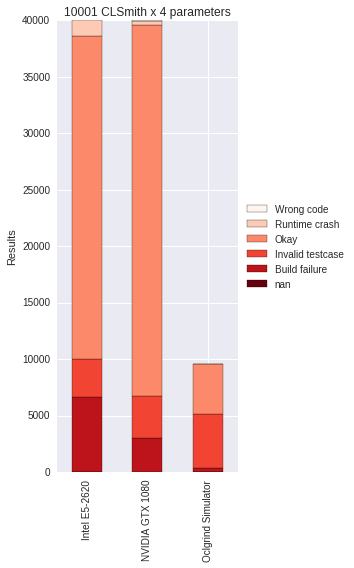

In [57]:
plot_outcomes(CLSmithResult, "CLSmith", dictname=classifications, key='Classification')

### CLSmith w. cldrive

In [15]:
outcomes["CLSmith w. cldrive"]
# classifications["CLSmith w. cldrive"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Unsupported Program,32899,94.828928
1,NVIDIA GTX 1080,z_Okay,1655,4.770415
2,NVIDIA GTX 1080,No OpenCL kernel,64,0.184475
3,NVIDIA GTX 1080,cldrive Error,56,0.161416
4,NVIDIA GTX 1080,Timeout,12,0.034589
5,NVIDIA GTX 1080,clWaitForEvents(),3,0.008647
6,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,3,0.008647
7,NVIDIA GTX 1080,Segmentation Fault,1,0.002882
8,Intel E5-2620,Unsupported Program,37940,94.840516
9,Intel E5-2620,z_Okay,1812,4.529547


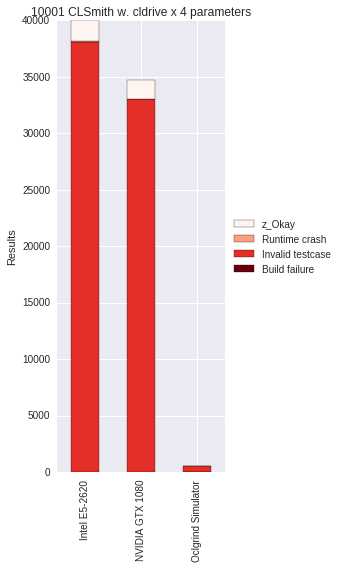

In [16]:
plot_outcomes(cldriveCLSmithResult, "CLSmith w. cldrive", dictname=classifications, key='Classification')

### GitHub

In [17]:
outcomes["GitHub"]
# classifications["GitHub"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Unsupported Program,17594,37.081375
1,NVIDIA GTX 1080,z_Okay,10019,21.116193
2,NVIDIA GTX 1080,cldrive Error,6816,14.365503
3,NVIDIA GTX 1080,Multiple OpenCL kernels,5330,11.233587
4,NVIDIA GTX 1080,No OpenCL kernel,5018,10.576011
5,NVIDIA GTX 1080,clWaitForEvents(),1502,3.165637
6,NVIDIA GTX 1080,Preprocessing Failed,726,1.530128
7,NVIDIA GTX 1080,INVALID_WORK_GROUP_SIZE,369,0.777710
8,NVIDIA GTX 1080,Timeout,68,0.143318
9,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,3,0.006323


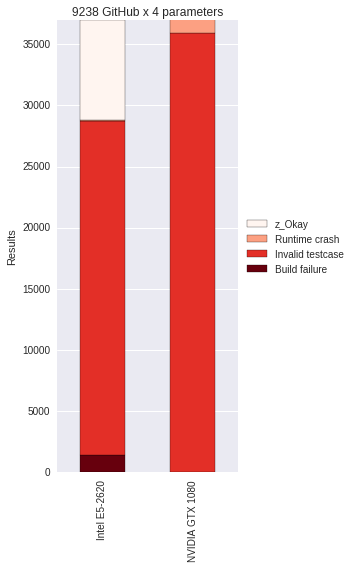

In [18]:
plot_outcomes(GitHubResult, "GitHub", dictname=classifications, key='Classification')

### CLgen

In [26]:
outcomes["CLgen"]
# classifications["CLgen"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,z_Okay,3994,99.85
1,NVIDIA GTX 1080,clWaitForEvents(),6,0.15
2,Intel E5-2620,z_Okay,3984,99.60
3,Intel E5-2620,Segmentation Fault,16,0.40


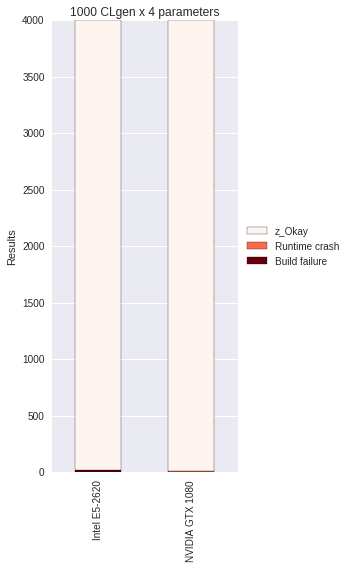

In [20]:
plot_outcomes(CLgenResult, "CLgen", dictname=classifications, key='Classification')

# Comparing Outputs

## TODO...

In [21]:
# q = session.query(CLgenResult).filter(CLgenResult.outcome == "Segmentation Fault")
# for r in q:
#     print(r.program_id)
#     print(r.program.src)

In [22]:
# for param in session.query(CLSmithParams).all():
#     suspicious = []

#     print("Params:", param)
#     programs_with_results = session.query(CLSmithProgram).filter(
#         CLSmithProgram.id.in_(session.query(CLSmithResult.program_id).filter(CLSmithResult.params_id == param.id)))
#     programs_with_good_results = session.query(CLSmithProgram).filter(
#         CLSmithProgram.id.in_(session.query(CLSmithResult.program_id).filter(
#             CLSmithResult.params_id == param.id, CLSmithResult.status == 0)))
#     ratio_good = programs_with_good_results.count() / programs_with_results.count()

#     print("  #. programs with results", programs_with_results.count())
#     print("  #. programs with good results", programs_with_good_results.count(), f"({ratio_good:.1%} of total)")

#     for program in programs_with_good_results.all():
#         q = session.query(CLSmithResult).filter(
#                 CLSmithResult.program_id == program.id, CLSmithResult.params_id == param.id)

#         stdout = set(r.stdout for r in q.all())
#         if len(stdout) > 1:
#             suspicious.append(q.first().program_id)

#     nsuspicious = len(suspicious)
#     ratio_suspicious = nsuspicious / programs_with_good_results.count()
#     print(f"  #. suspicious {nsuspicious} ({ratio_suspicious:.1%} of total)\n")